## State-Wise Universal Prediction Model for Non-voter-Group

- method 1: train model (logistic regression with elasticnet regulizer) on voter-group, predict on non-voter-group
- method 2: use transfer learning (TCA), to apply the feature transformation, then train model on voter-group, predict on non-voter-group




In [1]:
import pandas as pd
import numpy as np
import utils
# import model
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import matplotlib.pyplot as plt
import utils


# data path
file_path = '../data/cumulative_2022_v3_9_domain.csv'

data = pd.read_csv(file_path)

column_to_variable_dict = np.load('../data/column_to_variable_dict.npy', allow_pickle=True).item()
variable_to_column_dict = np.load('../data/variable_to_column_dict.npy', allow_pickle=True).item()

value_label_dict = np.load('../data/value_labels.npy', allow_pickle=True).item()

# check the "Year" column's max and min value
print(data['Year'].max())
print(data['Year'].min())

target_variable = 'Voted_D_R'

'''Voted_D_R  {0.0: '0. Did not vote; DK/NA if voted; refused to say if', 1.0: '1. Democrat', 2.0: '2. Republican'}'''




data_train = data[(data['Voted_D_R'] == 1) | (data['Voted_D_R'] == 2)]
data_test = data[data['Voted'] == 1]

data_new = pd.concat([data_train, data_test])

print('number of samples who vote Democrat : ', len(data_new[data_new[target_variable] == 1]))
print('number of samples who vote Republican: ', len(data_new[data_new[target_variable] == 2]))
print('number of samples who vote case DK : ', len(data_new[data_new[target_variable] == 0]))
print('number of samples who do not vote : ', len(data_test))
print('number of samples who do vote D or R : ', len(data_train))

2020.0
1948.0
number of samples who vote Democrat :  16419
number of samples who vote Republican:  14526
number of samples who vote case DK :  0
number of samples who do not vote :  17790
number of samples who do vote D or R :  30945


In [2]:
missing_value = utils.missing_value_analysis(data_new)


threshold_list = [0.2, 0.3, 0.4, 0.5]

'''
- Less than 20% missing in the last 10 years
- Less than 30% missing in the last 20 years
- Less than 40% missing in the last 30 years
- Less than 50% missing in the last 40 years

'''


# must_include_list = ['urbanism']
must_include_list = None


# folder_name = '../result/state-wise-universal_predict/'
folder_name = '../result/state-wise-universal_predict-add-year/'


used_features, not_used_features, folder_name = utils.feature_filter(data_new, threshold_list,column_to_variable_dict, folder_name, must_include_list)



In [3]:
# use the used features to filter out the data

# set the target variable set and index variable set, these variables will not be used for training

target_variable_list = ['Voted','Registered_voted','Voted_party','Vote_Nonvote_Pres','Voted_D_R']

# race_variable_list = ['Race3','Race4','Race7']

# religion_variable_list = ['religion']

# index_variable_list = ['VCF0006a','Year', ]
index_variable_list = ['VCF0006a',] # try to use the year as the feature


not_used_features = ['Pre_election_inten_vote']
# not_used_features = []


state_variable_list = ['State']

# non_feature_list = target_variable_list +  race_variable_list + religion_variable_list + index_variable_list + not_used_features + state_variable_list

non_feature_list = target_variable_list + index_variable_list + not_used_features + state_variable_list


year_threshold = 1948



# only use samples in WA state

# data_train = data_train[data_train['State'] == 'WA'].reset_index(drop=True)
# data_test = data_test[data_test['State'] == 'WA'].reset_index(drop=True)


folder_name = folder_name + '/'+ str(year_threshold)+ '/'

# folder_name = folder_name + '/WA/'+ str(year_threshold)+ '/'


# filter out the samples whose year > year_threshold
data_train = data_train[data_train['Year'] > year_threshold].reset_index(drop=True)
data_test = data_test[data_test['Year'] > year_threshold].reset_index(drop=True)

data_new = pd.concat([data_train, data_test]).reset_index(drop=True)

print(data_train.shape)
print(data_test.shape)
print(data_new.shape)


numerical_feature_list, categorical_feature_list = utils.feature_type_analysis(data_new, used_features, non_feature_list)



(30555, 120)
(17552, 120)
(48107, 120)
number of numerical features:  12
number of categorical features:  52
numerical features list: ['therm_Christians', 'therm_Mislims', 'therm_ChrFundament', 'therm_hispanics', 'therm_RepParty', 'therm_DemParty', 'therm_Whites', 'therm_liberals', 'therm_conservatives', 'therm_Blacks', 'Age', 'Year']


In [4]:
# get the state list

state_list = data['State'].unique()
print(len(state_list),state_list)

# remove "99" from the state list

state_list = state_list[state_list != '99']
print(len(state_list),state_list)

52 ['99' 'NY' 'OH' 'ID' 'MI' 'GA' 'NE' 'MA' 'KY' 'MO' 'NC' 'AR' 'MN' 'TN'
 'KS' 'WI' 'IN' 'CT' 'NJ' 'AL' 'OR' 'SD' 'LA' 'DC' 'CA' 'CO' 'NM' 'IL'
 'PA' 'TX' 'SC' 'MS' 'IA' 'MD' 'WA' 'VA' 'FL' 'ME' 'UT' 'OK' 'AZ' 'WV'
 'WY' 'DE' 'NH' 'HI' 'NV' 'ND' 'RI' 'VT' 'MT' 'AK']
51 ['NY' 'OH' 'ID' 'MI' 'GA' 'NE' 'MA' 'KY' 'MO' 'NC' 'AR' 'MN' 'TN' 'KS'
 'WI' 'IN' 'CT' 'NJ' 'AL' 'OR' 'SD' 'LA' 'DC' 'CA' 'CO' 'NM' 'IL' 'PA'
 'TX' 'SC' 'MS' 'IA' 'MD' 'WA' 'VA' 'FL' 'ME' 'UT' 'OK' 'AZ' 'WV' 'WY'
 'DE' 'NH' 'HI' 'NV' 'ND' 'RI' 'VT' 'MT' 'AK']


In [5]:
target_variable = 'Voted_D_R'

def state_wise_universal_prediction(state_name, result_dict, data_train,  data_test, target_variable,numerical_feature_list, categorical_feature_list, value_label_dict, folder_name):

    folder_name_state = folder_name + state_name + '/'

    if state_name != 'all':

        data_train_state = data_train[data_train['State'] == state_name ].reset_index(drop=True)
        data_test_state = data_test[data_test['State'] == state_name ].reset_index(drop=True)

    else:
        data_train_state = data_train
        data_test_state = data_test

    Y_target_predict,D_R_stats = utils.universal_predict(data_train_state,data_test_state , numerical_feature_list, categorical_feature_list, target_variable, value_label_dict, folder_name_state, group='regular', group_cat='')

    # coner case: if the number of samples in the test set is 0, we do not need to do TCA

    if len(data_test_state) > 0:

        Y_target_predict_TCA, Xs_new, Xt_new,X_continuous_categorical_train, X_continuous_categorical_test,D_R_stats_TCA = utils.universal_predict_TCA(data_train_state, data_test_state, numerical_feature_list, categorical_feature_list, target_variable, value_label_dict, folder_name_state, group='TCA', group_cat='')

    else: 
        D_R_stats_TCA = D_R_stats 
    

    result_dict['regular'][state_name] = D_R_stats
    result_dict['TCA'][state_name]=D_R_stats_TCA

    return result_dict


result_dict = {'regular':{},'TCA':{}}

for state_name in  list(state_list)+['all'] :
    
        result_dict = state_wise_universal_prediction(state_name, result_dict,  data_train,  data_test,target_variable,numerical_feature_list, categorical_feature_list,value_label_dict, folder_name)


(3007, 65)
average accuracy:  0.8672700216450216
average recall:  0.8808291708291709
average precision:  0.8845200523144362
average f1 score:  0.882402363357657
average roc auc score:  0.8653578580568515
1    686
0    400
dtype: int64
(3007, 65)
average accuracy:  0.8714339826839825
average recall:  0.8828712953712954
average precision:  0.8895660087054745
average f1 score:  0.8859097334384455
average roc auc score:  0.8700643381709403
1    650
0    436
dtype: int64
number of samples of Democratic:  650
number of samples of Repub:  436
(2142, 65)
average accuracy:  0.8666967485069674
average recall:  0.8666353668933493
average precision:  0.8546477818477818
average f1 score:  0.8603500120759622
average roc auc score:  0.8663106862203499
1    443
0    326
dtype: int64
(2142, 65)
average accuracy:  0.882009289980093
average recall:  0.8708496066444182
average precision:  0.8796310998222779
average f1 score:  0.8747720438447208
average roc auc score:  0.8810584994079782
0    407
1    362


In [6]:
# save the result_dict

np.save(folder_name + 'result_dict.npy', result_dict)

# 
import numpy as np
import pandas as pd
# result_dict = np.load(folder_name + 'result_dict.npy', allow_pickle=True).item()

In [7]:
# make result_dict into a dataframe

def result_dict_to_df(result_dict, folder_name, method='regular'):

    result_dict_df = pd.DataFrame(result_dict[method]).T

    # add extra columns to the dataframe, ratio of total vote_D and vote_R,

    result_dict_df['ratio_total_vote_D'] = (result_dict_df['N_total_vote_D'] /( result_dict_df['N_total_vote_D']+result_dict_df['N_total_vote_R'])).round(3)
    result_dict_df['ratio_total_vote_R'] = (result_dict_df['N_total_vote_R'] / (result_dict_df['N_total_vote_D']+result_dict_df['N_total_vote_R'])).round(3)

    # save the result_dict_df

    result_dict_df.to_csv(folder_name + 'state_wise_result_'+ method + '.csv')

    return result_dict_df

result_dict_df = result_dict_to_df(result_dict, folder_name, 'regular')
result_dict_df_TCA = result_dict_to_df(result_dict, folder_name, 'TCA')

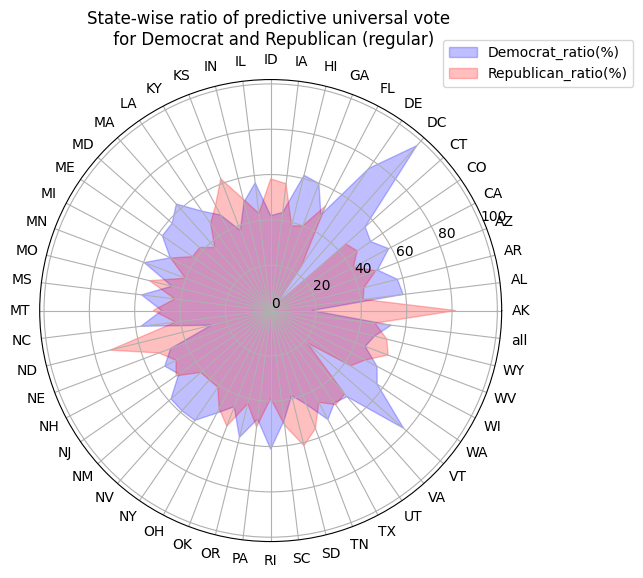

In [8]:
# visualizationby the radar plot

# def radar_ploting

import matplotlib.pyplot as plt

# sort the index of the result_dict_df by the capital letter of the state name

result_dict_df = result_dict_df.sort_index()

labels = result_dict_df.index

states_ratio = result_dict_df[['ratio_total_vote_D','ratio_total_vote_R']].values

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()

states_ratio=np.concatenate((states_ratio,[states_ratio[0]]))
angles+=angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, states_ratio[:,0]*100, color='blue', alpha=0.25, label='Democrat_ratio(%)')
ax.fill(angles, states_ratio[:,1]*100, color='red', alpha=0.25, label='Republican_ratio(%)')

ax.set_yticks(range(0, 101, 20))
# ax.set_yticklabels(map(str, range(0, 101, 20)), color='grey', size=7)
ax.set_thetagrids([a * 180/np.pi for a in angles[:-1]], labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.title('State-wise ratio of predictive universal vote \n for Democrat and Republican (regular)')
plt.show()


fig.savefig(folder_name + 'state_wise_ratio_regular.png')

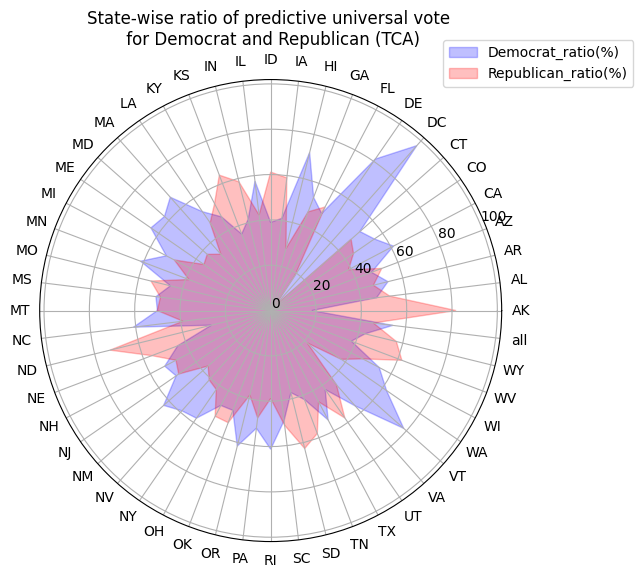

In [9]:
# visualizationby the radar plot

# def radar_ploting

import matplotlib.pyplot as plt

# sort the index of the result_dict_df by the capital letter of the state name

result_dict_df = result_dict_df_TCA.sort_index()

labels = result_dict_df.index

states_ratio = result_dict_df[['ratio_total_vote_D','ratio_total_vote_R']].values

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()

states_ratio=np.concatenate((states_ratio,[states_ratio[0]]))
angles+=angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, states_ratio[:,0]*100, color='blue', alpha=0.25, label='Democrat_ratio(%)')
ax.fill(angles, states_ratio[:,1]*100, color='red', alpha=0.25, label='Republican_ratio(%)')

ax.set_yticks(range(0, 101, 20))
# ax.set_yticklabels(map(str, range(0, 101, 20)), color='grey', size=7)
ax.set_thetagrids([a * 180/np.pi for a in angles[:-1]], labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
plt.title('State-wise ratio of predictive universal vote \n for Democrat and Republican (TCA)')
plt.show()


fig.savefig(folder_name + 'state_wise_ratio_TCA.png')

In [7]:




# target_variable = 'Voted_D_R'

# Y_target_predict = utils.universal_predict(data_train,data_test, numerical_feature_list, categorical_feature_list, target_variable, value_label_dict, folder_name, group='', group_cat='')

